# Improved Training of Wasserstein GANs in Pytorch

Pytorch implementation by Thomas Viehmann, tv@lernapparat.de

## Introduction

Wasserstein GANs have been introduced in [Arjovsky et al: Wasserstein GAN](https://arxiv.org/abs/1701.07875).
There also is a [great summary of the article by Alex Irpan](http://www.alexirpan.com/2017/02/22/wasserstein-gan.html).

Recently, [Gulrajani et al: Improved Training of Wasserstein GANs](https://www.arxiv.org/abs/1704.00028) added a relaxed constraint to the original Wasserstein GAN discriminator training objective. I wrote my take at what is up with that in [Geometric Intuition on Improved Wasserstein GANs](https://lernapparat.de/improved-wasserstein-gan/) and also thought that maybe one could take a step back - namely stick with $|f(x)-f(y)| = |x-y|$ instead of testing $|\nabla f| = 1$ (see the [*Semi-Improved Training of Wasserstein GANs* section](https://lernapparat.de/improved-wasserstein-gan/) for details or the [Notebook](https://github.com/t-vi/pytorch-tvmisc/blob/master/wasserstein-distance/Semi-Improved_Training_of_Wasserstein_GAN.ipynb)).

Now that pytorch gained support for second derivatives, I wanted to also implement the improved training method directly.
MyLeakyReLU below needs torch.clamp with second derivatives, which is in [this github pull request](https://github.com/pytorch/pytorch/pull/1514).

## Acknowledgement

This is based on the semi-improved notebook, which borrows heavily from the code accompanying the two papers, namely
- https://github.com/martinarjovsky/WassersteinGAN (initialisation, loss calculation and training loop)
- https://github.com/igul222/improved_wgan_training (toy problem data generation and network structure, visualization)

Please see the licenses there and refer to the above when using their code.
I applaud publishing the code with the papers. This was crucial in enabling this exercise.

## Code, code, everone wants code!

Here it is. I have left the semi-improved code in there, too. Setting `lipschitz_constraint = 3` gets you the improved version.

In [1]:
# import everything
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import os
import numpy
import sklearn.datasets

from matplotlib import pyplot
%matplotlib inline
import IPython

In [2]:
# set up parameters, a blend of Wasserstein GAN and Improved Training's code

lipschitz_constraint = 3 # 0: original WGAN, 1: semi-improved method 1
                         # 2: semi-improved method 2
                         # 3: improved method with gradient penalty
penalty_weight = 0.1     # penalty weight term lambda 

opt_dataset = '25gaussians' # 8gaussians | swissroll | 25gaussians
opt_niter = 10000
opt_batchSize=256
opt_lrD = 0.00005 # learning rate for Critic, default=0.00005
opt_lrG = 0.00005 # learning rate for Generator, default=0.00005
opt_beta1=0.5 # beta1 for adam. default=0.5
opt_cuda = True
opt_clamp_lower = -0.01 #default -0.01
opt_clamp_upper =  0.01 #default  0.01
opt_Diters = 5 # number of D iters per each G iter
opt_adam = False  # Whether to use adam (default False is rmsprop)
opt_prefix = None # whether to write images (=prefix of type string) or show in notebook (=None)

opt_manualSeed = 15042017
print("Random Seed: ", opt_manualSeed)
random.seed(opt_manualSeed)
numpy.random.seed(opt_manualSeed)
torch.manual_seed(opt_manualSeed)
cudnn.benchmark = True

Random Seed:  15042017


In [3]:
# set up variables (torch administrativa)

input = torch.FloatTensor(opt_batchSize, 2)
input2 = torch.FloatTensor(opt_batchSize, 2)
interp_alpha = torch.FloatTensor(opt_batchSize, 1)
noise = torch.FloatTensor(opt_batchSize, 2)
fixed_noise = torch.FloatTensor(opt_batchSize, 2).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

if opt_cuda:
    input = input.cuda()
    input2 = input2.cuda()
    interp_alpha = interp_alpha.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

input = Variable(input)
input2 = Variable(input2)
noise = Variable(noise)
interp_alpha = Variable(interp_alpha)
fixed_noise = Variable(fixed_noise)


In [4]:
# Dataset generator largely form Improved Training of Wasserstein GAN code (see link above)
def inf_train_gen(DATASET='8gaussians', BATCH_SIZE=opt_batchSize):
    if DATASET == '25gaussians':
        dataset = []
        for i in range(100000//25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = numpy.random.randn(2)*0.05
                    point[0] += 2*x
                    point[1] += 2*y
                    dataset.append(point)
        dataset = numpy.array(dataset, dtype='float32')
        numpy.random.shuffle(dataset)
        dataset /= 2.828 # stdev
        while True:
            for i in range(len(dataset)//BATCH_SIZE):
                yield torch.from_numpy(dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield torch.from_numpy(data)

    elif DATASET == '8gaussians':
    
        scale = 2.
        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (1./numpy.sqrt(2), -1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), -1./numpy.sqrt(2))
        ]
        centers = [(scale*x,scale*y) for x,y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = numpy.random.randn(2)*.02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = numpy.array(dataset, dtype='float32')
            dataset /= 1.414 # stdev
            yield torch.from_numpy(dataset)



In [5]:
# Generates and saves a plot of the true distribution, the generator, and the
# critic.
# largely form Improved Training of Wasserstein GAN code (see link above)
class ImageGenerator:
  def __init__(self, netG, netD, prefix='frame', noise_dim=2):
    self.prefix = prefix
    self.frame_index = 1
    self.noise_dim = noise_dim
    self.netG = netG
    self.netD = netD
    
  def __call__(self, true_dist,losses):
    N_POINTS = 128
    RANGE = 3

    points = numpy.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:,:,0] = numpy.linspace(-RANGE, RANGE, N_POINTS)[:,None]
    points[:,:,1] = numpy.linspace(-RANGE, RANGE, N_POINTS)[None,:]
    points = points.reshape((-1,2))
    points = Variable(torch.from_numpy(points).cuda())
    
    noise = torch.FloatTensor().resize_(batch_size, 2)
    noise.normal_(0, 1)
    noise = Variable(noise.cuda())

    fake = self.netG(noise)
    samples = fake.data.cpu().numpy()

    disc_points = self.netD(points)
    
    disc_map = disc_points.data.cpu().numpy()
    pyplot.clf()
    if self.prefix is None:
        #pyplot.suplots(nrows=1, ncols=2)
        pyplot.subplot(1,2,1)
    x = y = numpy.linspace(-RANGE, RANGE, N_POINTS)
    pyplot.contour(x,y,disc_map.reshape((len(x), len(y))))

    true_dist = true_dist.cpu().numpy()
    pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
    pyplot.scatter(samples[:, 0],   samples[:, 1],   c='green', marker='+')
    if self.prefix is not None:
      pyplot.savefig(self.prefix+'{:05d}'.format(self.frame_index)+'.jpg')
    else:
      pyplot.subplot(1,2,2)
      pyplot.plot(losses)
      IPython.display.clear_output(wait=True)
      IPython.display.display(pyplot.gcf())
    self.frame_index += 1


Define the Generator and Critic, I use my own LeakyReLU until second derivatives are available for the standard one.

In [6]:
class MyLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(MyLeakyReLU, self).__init__()
        self.negative_slope = negative_slope
    def forward(self, x):
        return torch.clamp(x, min=0.0)+torch.clamp(x, max=0.0)*self.negative_slope

class ToyGAN_G(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=2):
        super(ToyGAN_G, self).__init__()
        self.dim_hidden, self.dim_out, self.noise_dim = dim_hidden, dim_out, noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_out)
            )
    def forward(self, x):
        x = self.net(x)
        return x

class ToyGAN_D(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(ToyGAN_D, self).__init__()
        self.dim_hidden, self.dim_gen_out = dim_hidden, dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, 1)
            )
    def forward(self, x): #?
        x = self.net(x)
        return x


Do the training (code largely taken from Wasserstein GAN code, see link above). I am using two optimizers for the discrimination terms and the Lipschitz penalty. This is because I have not yet fully understood whether autograd needs a zero_grad before the first derivative to compute the second derivative.

Alternatively one could store and add the gradients similar to the correction term and use one optimizer but the same calculation setup.

[9999/10000] Loss_D: -0.038523 Loss_G: -3.254443 Loss_D_real: -3.333817 Loss_D_fake -3.295294 Loss_lip 0.001694


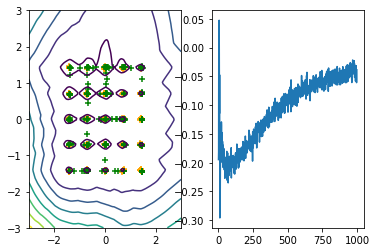

In [7]:
data_generator = inf_train_gen(opt_dataset)
netD = ToyGAN_D()
netG = ToyGAN_G()
netD.cuda()
netG.cuda()

generate_image = ImageGenerator(netG, netD, prefix=opt_prefix)

if opt_adam:
    optimizerD = optim.Adam(netD.parameters(), lr=opt_lrD, betas=(opt_beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt_lrG, betas=(opt_beta1, 0.999))
    if lipschitz_constraint == 3:
        optimizerD2 = optim.Adam(netD.parameters(), lr=opt_lrD, betas=(opt_beta1, 0.999))
else:
    optimizerD = optim.RMSprop(netD.parameters(), lr = opt_lrD)
    optimizerG = optim.RMSprop(netG.parameters(), lr = opt_lrG)
    if lipschitz_constraint == 3:
        optimizerD2 = optim.RMSprop(netD.parameters(), lr = opt_lrD)

losses = []
for batches in range(opt_niter):
    ############################
    # (1) Update D network
    ###########################
    for p in netD.parameters(): # reset requires_grad
        p.requires_grad = True # they are set to False below in netG update

    # train the discriminator Diters times
    if batches < 25 or batches % 500 == 0:
        Diters = 100
    else:
        Diters = opt_Diters
    for j in range(Diters):

        if lipschitz_constraint == 0:
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(opt_clamp_lower, opt_clamp_upper)

        data = next(data_generator)

        # train with real
        real_cpu = data
        netD.zero_grad()
        batch_size = real_cpu.size(0)
        input.data.resize_(real_cpu.size()).copy_(real_cpu)

        errD_real_vec = netD(input)
        errD_real = errD_real_vec.mean(0).view(1)
        errD_real.backward(one, retain_variables=(lipschitz_constraint>0))

        # train with fake
        noise.data.resize_(batch_size, 2)
        noise.data.normal_(0, 1)
        fake = netG(noise)
        input2.data.resize_(fake.data.size()).copy_(fake.data)
        errD_fake_vec = netD(input2)
        errD_fake = errD_fake_vec.mean(0).view(1)
        errD_fake.backward(mone, retain_variables=(lipschitz_constraint>0))
        errD = errD_real - errD_fake
        # This is the semi-improved training penalty term to soft-enforce the Lipschitz 1 bound)
        # Note how we conditionally retained variables and disabled the weight clipping above
        if lipschitz_constraint == 1:
            dist = ((input-input2)**2).sum(1)**0.5
            lip_est = (errD_real_vec-errD_fake_vec).abs()/(dist+1e-8)
            lip_loss = penalty_weight*((1.0-lip_est)**2).mean(0).view(1)
            lip_loss.backward(one)
            errD = errD + lip_loss
        elif lipschitz_constraint == 2:
            interp_alpha.data.resize_(batch_size, 1)
            interp_alpha.data.uniform_()
            dist = ((input-input2)**2).sum(1)**0.5
            errD_interp_vec = netD(interp_alpha.expand_as(input)*input+(1-interp_alpha.expand_as(input))*input2)
            lip_est1 = (errD_fake_vec-errD_interp_vec).abs()/(interp_alpha*dist+1e-8)
            lip_est2 = (errD_real_vec-errD_interp_vec).abs()/((1.0-interp_alpha)*dist+1e-8)
            lip_loss = 0.5*penalty_weight*(((1.0-lip_est1)**2).mean(0).view(1)+((1.0-lip_est2)**2).mean(0).view(1))
            lip_loss.backward(one)
            errD = errD + lip_loss
        elif lipschitz_constraint == 3:
            optimizerD.step()
            netD.zero_grad()
            
            interp_alpha.data.resize_(batch_size, 1)
            interp_alpha.data.uniform_()
            interp_points = Variable((interp_alpha.expand_as(input)*input+(1-interp_alpha.expand_as(input))*input2).data, requires_grad=True)
            errD_interp_vec = netD(interp_points)
            torch.autograd.backward(errD_interp_vec, create_graph=True)
            errD_gradient = interp_points.grad
            #print ([type(p.grad) for p in netD.parameters()])
            errD_grads = [p.grad.data.clone() for p in netD.parameters()]
            lip_est = (errD_gradient**2).view(batch_size,-1).sum(1)
            lip_loss = penalty_weight*((1.0-lip_est)**2).mean(0).view(1)
            lip_loss.backward()
            
            for p1,p2 in zip(netD.parameters(),errD_grads):
                p1.grad.data -= p2
            ### what to do with the old gradients?
            optimizerD2.step()
            
        if lipschitz_constraint != 3:
            optimizerD.step()

    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = False # to avoid computation
    netG.zero_grad()
    # in case our last batch was the tail batch of the dataloader,
    # make sure we feed a full batch of noise
    noise.data.resize_(opt_batchSize, 2)
    noise.data.normal_(0, 1)
    fake = netG(noise)
    errG = netD(fake)
    errG = errG.mean(0).view(1)
    errG.backward(one)
    optimizerG.step()
    if (batches+1) % 10 == 0:
      losses.append(errD.data[0])
      generate_image(data, losses)
      print('[%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f Loss_lip %f'
        % (batches, opt_niter,
        errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], lip_loss.data[0]))

IPython.display.clear_output(wait=True)
print('[%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f Loss_lip %f'
        % (batches, opt_niter,
        errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], lip_loss.data[0]))


Things to try:
- Systematically compare Improved vs. Semi-Improved Training of Wasserstein GAN.
  I am still unsure whether it might be preferrable to have the Lipschitz constant tested directly rather than using the gradient.
- Check whether Adam works reliably, too.
- Find out how to really do second derivatives in pytorch and improve the code.
  In particular, only use one optimizer.

I appreciate your feedback: Thomas Viehmann, tv@lernapparat.de